## Get data and packages

In [1]:
import os

os.chdir(os.path.join(os.getcwd(), '..'))
import src.preprocessing
import src.model_training
import src.feature_engineering

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time
import shap
import lightgbm as lgb
import joblib

import json
import sys

from verstack import LGBMTuner
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = src.feature_engineering.get_train_data('data/data_pricing_challenge.csv')
df.head()

,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at,diesel,electro,hybrid_petrol,petrol,beige,black,blue,brown,green,grey,orange,red,silver,white,convertible,coupe,estate,hatchback,sedan,subcompact,suv,van,antiquity,avg_price,avg_mileage,avg_antiquity,avg_engine_power
0,140411,100,2012-02-01,diesel,black,convertible,1,1,0,0,1,1,1,0,11300,2018-01-01,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5.916496,9768.79,130799.10,6.19,103.42
1,13929,317,2016-04-01,petrol,grey,convertible,1,1,0,0,0,1,1,1,69700,2018-02-01,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1.837098,61650.00,41669.50,2.46,317.00
2,183297,120,2012-04-01,diesel,white,convertible,0,0,0,0,1,0,1,0,10200,2018-02-01,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,5.837098,12427.21,153493.65,5.64,126.22
3,128035,135,2014-07-01,diesel,red,convertible,1,1,0,0,1,1,1,1,25100,2018-02-01,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,3.589322,23931.82,86178.64,3.74,132.20
4,97097,160,2014-12-01,diesel,silver,convertible,1,1,0,0,0,1,1,1,33400,2018-04-01,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,3.331964,31000.00,76673.50,3.38,160.00


Model Training

In [3]:
target = 'price'
variables = src.model_training.txt_load('utils/model_variables.txt')
hyperparameters = src.model_training.json_load('utils/model_hyperparameters.json')

# Add L1 and L2 regularization
# hyperparameters['reg_alpha'] = 0.8
# hyperparameters['reg_lambda'] = 0.1

X = df.loc[:, variables]
y = df.loc[:, [target]]

In [4]:
# Initial tune to optimize hyperparameters

# tuner = LGBMTuner(metric = 'rmse', random_state = 123)
# tuner.fit(X, y['price'])

In [5]:
X_train, X_test, y_train, y_test = src.model_training.split_dataset(df, variables, target, 0.3)

In [6]:
model = src.model_training.lightgbm_training(X_train, y_train, hyperparameters)

In [7]:
results = X_test.copy()
results = results.assign(
    price_real = y_test,
    price_pred = model.predict(X_test)
)
results['error'] = results['price_real'] - results['price_pred']
results.sort_values(by='error', ascending = True).head(10)

,mileage,engine_power,antiquity,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,estate,hatchback,sedan,suv,avg_mileage,avg_antiquity,avg_engine_power,price_real,price_pred,error
1963,23755,190,2.499658,1,1,1,0,1,1,1,1,0,1,0,0,61485.00,3.19,190.00,29200,42631.987898,-13431.987898
1756,29464,160,4.413415,0,0,0,0,0,0,0,0,0,1,0,0,106524.80,5.01,159.00,9500,21036.964012,-11536.964012
4459,65918,120,2.247775,1,1,1,1,0,1,1,1,0,0,0,1,134700.06,5.46,134.44,15600,27053.999629,-11453.999629
1451,174817,135,5.081451,1,1,1,0,1,1,1,1,1,0,0,0,154519.53,5.51,127.71,4800,16130.994002,-11330.994002
112,12634,142,1.661875,1,1,0,0,1,0,1,1,0,0,0,0,86178.64,3.74,132.20,17800,28588.777476,-10788.777476
4706,80510,140,3.085558,1,1,0,0,0,0,1,1,0,0,0,1,80901.56,3.13,154.22,19000,29709.763208,-10709.763208
2060,66690,135,3.832991,1,1,0,1,1,0,1,0,0,1,0,0,81601.36,3.23,133.18,13200,23350.442256,-10150.442256
2851,62200,140,1.746749,0,1,0,0,1,1,1,1,0,0,1,0,154519.53,5.51,127.71,16700,26132.731899,-9432.731899
2886,134590,127,4.750171,1,1,0,0,1,1,1,0,0,0,1,0,153493.65,5.64,126.22,6000,14938.795784,-8938.795784
171,175096,160,4.580424,0,0,0,0,0,0,0,1,1,0,0,0,167663.14,6.44,152.71,6500,15145.638389,-8645.638389


In [8]:
import plotly.express as px

max_value = 70000

fig = px.scatter(results, x='price_real', y='price_pred', title='Price Real vs Pred', width = 700, height = 700)

# Agregar la línea y=x en rojo
fig.add_trace(px.line(x=[0, max_value], y=[0, max_value]).update_traces(line_shape='linear', line_color='red').data[0])

fig.update_xaxes(range=[0, max_value])
fig.update_yaxes(range=[0, max_value])

fig.show()

Plots and Model Performance Analysis

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

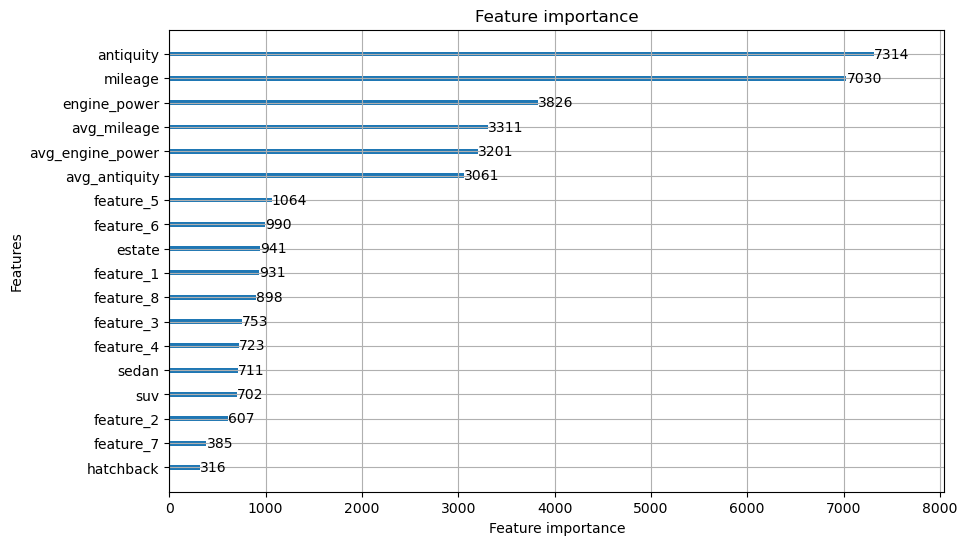

In [9]:
lgb.plot_importance(model, max_num_features=30, figsize=(10, 6))

In [10]:
src.model_training.model_results(model, X_train, X_test, y_train, y_test)

Model Results:

RMSE train: 1772.7817363501013
RMSE test: 2665.9339652313533

MAE train: 1200.4274307275098
MAE test: 1753.9790611735534

R2 train: 0.9532210392321492
R2 test: 0.9095318245994384


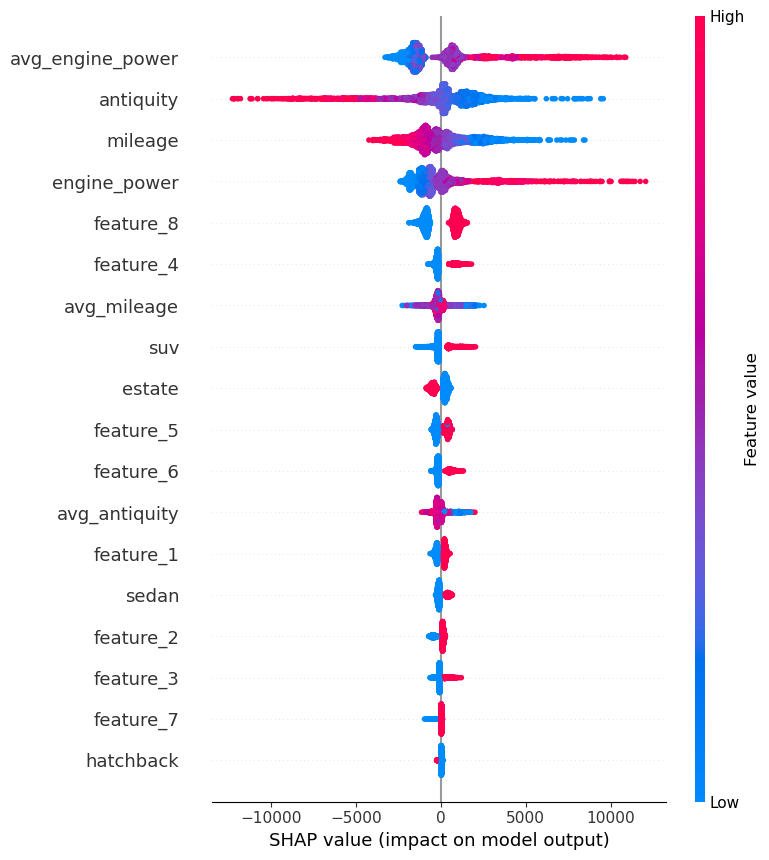

In [11]:
explainer, shap_values = src.model_training.calculate_shap_values(model, X_train)

# Visualize Shapley values
shap.summary_plot(shap_values, X_train)

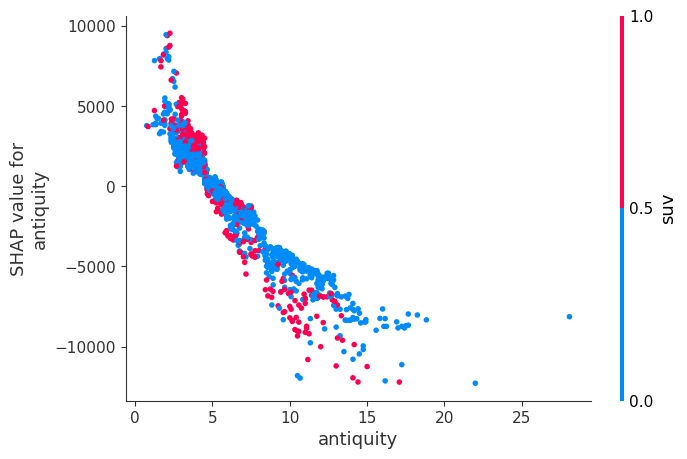

In [15]:
feature_names = X_train.columns.tolist()

# Seleccionar las variables que te interesan (puedes usar los nombres directamente)
variable1_name = 'antiquity'
variable2_name = 'suv'

# Encontrar los índices correspondientes a los nombres de las variables
variable1_index = feature_names.index(variable1_name)
variable2_index = feature_names.index(variable2_name)

# Crear un Dependence Plot
shap.dependence_plot(variable1_index, shap_values, X_train, feature_names=feature_names, interaction_index=variable2_index, show=False)
plt.show()

In [14]:
src.model_training.save_model(model, '\model')